# Assignment 2: Decision Tree Implementation and Pruning

**Name/Group ID:** [Your Name or Group ID Here]

**Date:** April 1, 2025

**Course:** BBM 409 - Machine Learning Laboratory

---

## Setup - Install Libraries

* **Explanation:** Install the required Python libraries using pip. Specify the versions used, as required by the assignment instructions for reproducibility. Uncomment and edit the example lines as needed.

In [ ]:
# Use this cell to install any necessary libraries with specific versions
# Example:
# !pip install pandas==2.1.4
# !pip install numpy==1.26.3
# !pip install scikit-learn==1.4.0
# !pip install matplotlib==3.8.2
# !pip install seaborn==0.13.1

## Setup - Import Libraries

* **Explanation:** Import all the necessary libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), and the allowed train/test split function from Scikit-Learn. Import any other standard Python libraries needed (e.g., `math`, `collections`, `copy`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # Allowed exception
import math
from collections import Counter
import copy # For deep copying the tree before pruning

# Configure visualizations
%matplotlib inline
sns.set_style('darkgrid')

print("Libraries imported.")

Libraries imported.


## Part 1 - Data Loading

* **Explanation:** Load the 'Financial Risk Assessment' dataset using Pandas. Display basic information like the first few rows (`.head()`), column data types and non-null counts (`.info()`), and summary statistics (`.describe()`) to get an initial understanding.

In [2]:
# Load the Financial Risk Assessment dataset
df = pd.read_csv('financial_risk_assessment.csv')
print("Dataset loaded successfully.")

# Display basic information about the dataset
print("\nDataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nDataset Head:")
print(df.head())
print("\nDataset Description (Numerical Features):")
print(df.describe())
print("\nDataset Description (Categorical Features):")
print(df.describe(include='object'))

Dataset loaded successfully.

Dataset Shape: (15000, 20)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    15000 non-null  int64  
 1   Gender                 15000 non-null  object 
 2   Education Level        15000 non-null  object 
 3   Marital Status         15000 non-null  object 
 4   Income                 12750 non-null  float64
 5   Credit Score           12750 non-null  float64
 6   Loan Amount            12750 non-null  float64
 7   Loan Purpose           15000 non-null  object 
 8   Employment Status      15000 non-null  object 
 9   Years at Current Job   15000 non-null  int64  
 10  Payment History        15000 non-null  object 
 11  Debt-to-Income Ratio   15000 non-null  float64
 12  Assets Value           12750 non-null  float64
 13  Number of Dependents   12750 non-n

In [4]:
def show_piechart(col, plot=None):
    values = df[col].value_counts()
    if plot:
        wedges, texts, autotexts = plot.pie(values, labels=values.index, autopct='%1.1f%%', colors=sns.color_palette("magma"))
        plot.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    else:
        wedges, texts, autotexts = plt.pie(values, labels=values.index, autopct='%1.1f%%', colors=sns.color_palette("magma"))
        plt.title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    
    for text in texts:  
        text.set_fontweight('bold')
    
    for autotext in autotexts:  
        autotext.set_color('white')
    
    # label
    for text in texts:  
        text.set_fontweight('bold')
    # percentage text
    for autotext in autotexts:  
        autotext.set_color('white')

## Part 1 - Data Visualization & Exploration

* **Explanation:** Creating various plots to visualize the data. This helps in understanding feature distributions, relationships between features, the distribution of the target variable ('Risk Rating'), and identifying potential issues like outliers or class imbalance.

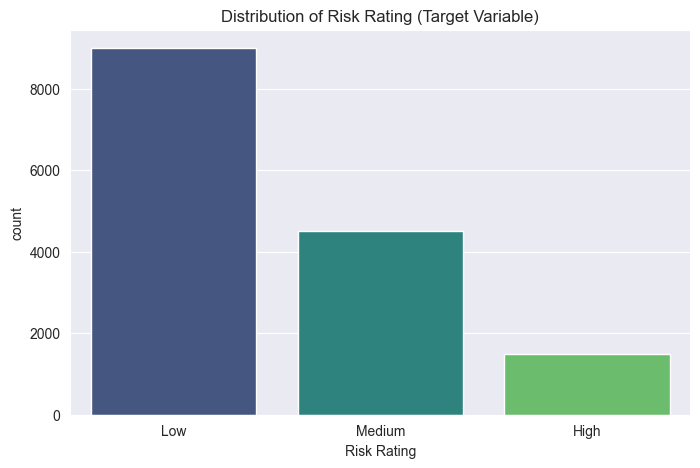

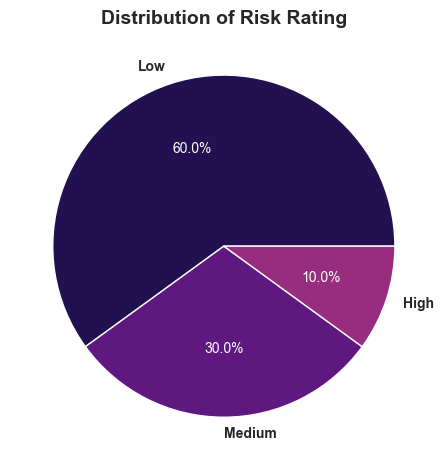

In [6]:
# Target
target_col = 'Risk Rating'
plt.figure(figsize=(8, 5))
sns.countplot(x=target_col, data=df, palette='viridis', legend=False, hue=target_col)
plt.title('Distribution of Risk Rating (Target Variable)')
plt.show()

show_piechart(target_col)
plt.tight_layout()


Numerical Features: ['Age', 'Income', 'Credit Score', 'Loan Amount', 'Years at Current Job', 'Debt-to-Income Ratio', 'Assets Value', 'Number of Dependents', 'Previous Defaults', 'Marital Status Change']


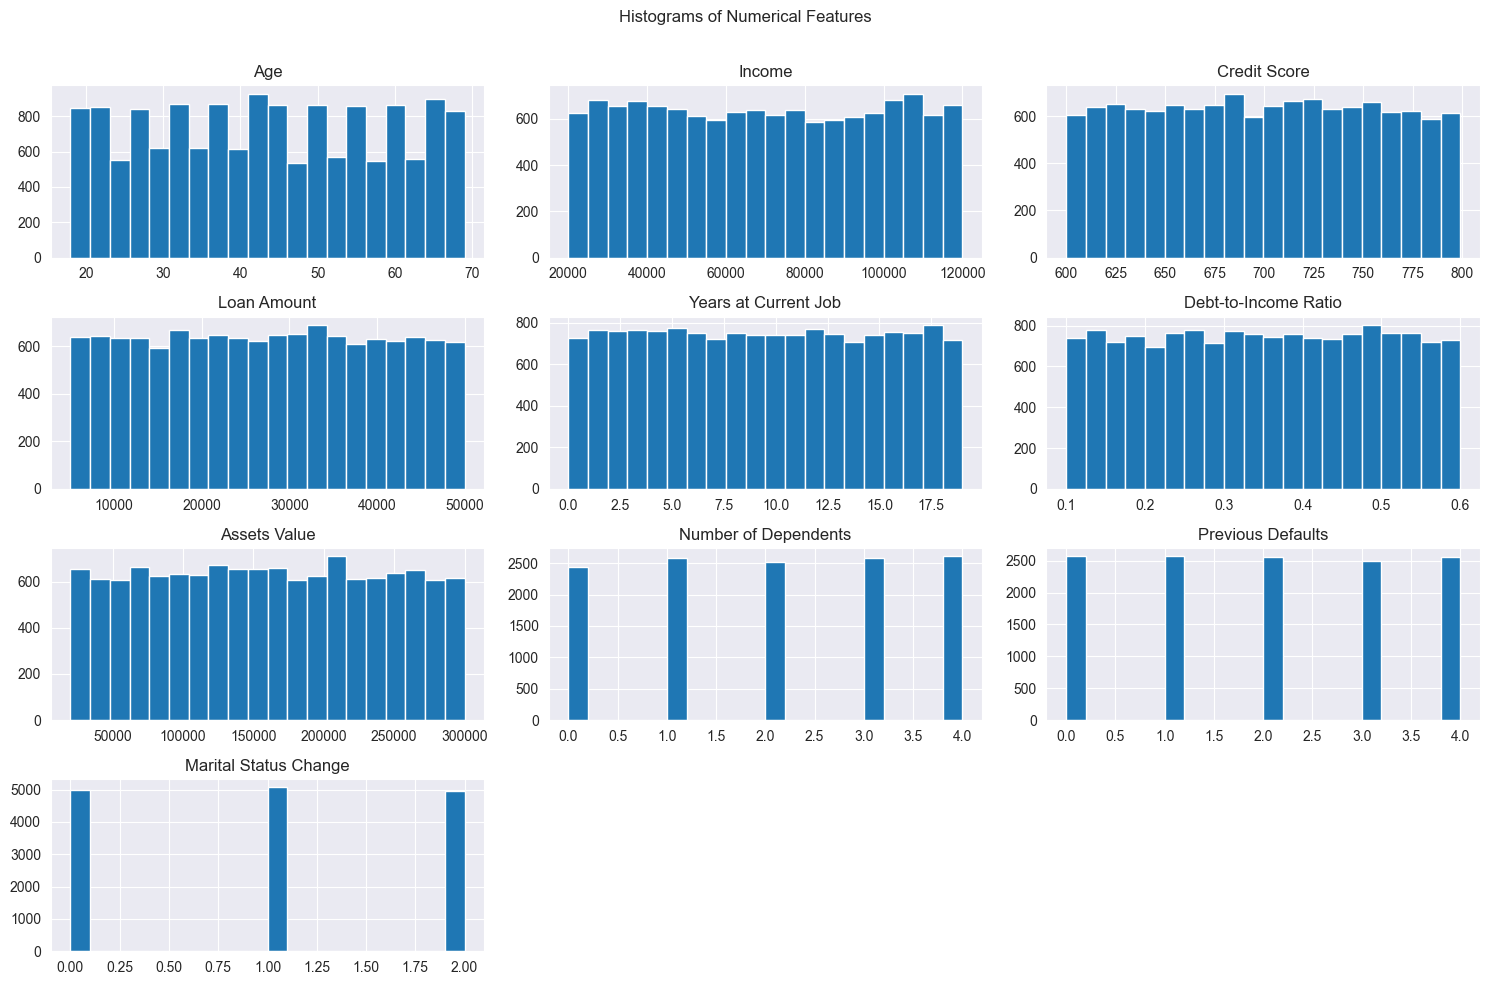

In [8]:
# --- Numerical Feature Distributions ---
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
print(f"\nNumerical Features: {numerical_features}")
df[numerical_features].hist(bins=20, figsize=(15, 10), layout=(-1, 3))
plt.suptitle('Histograms of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

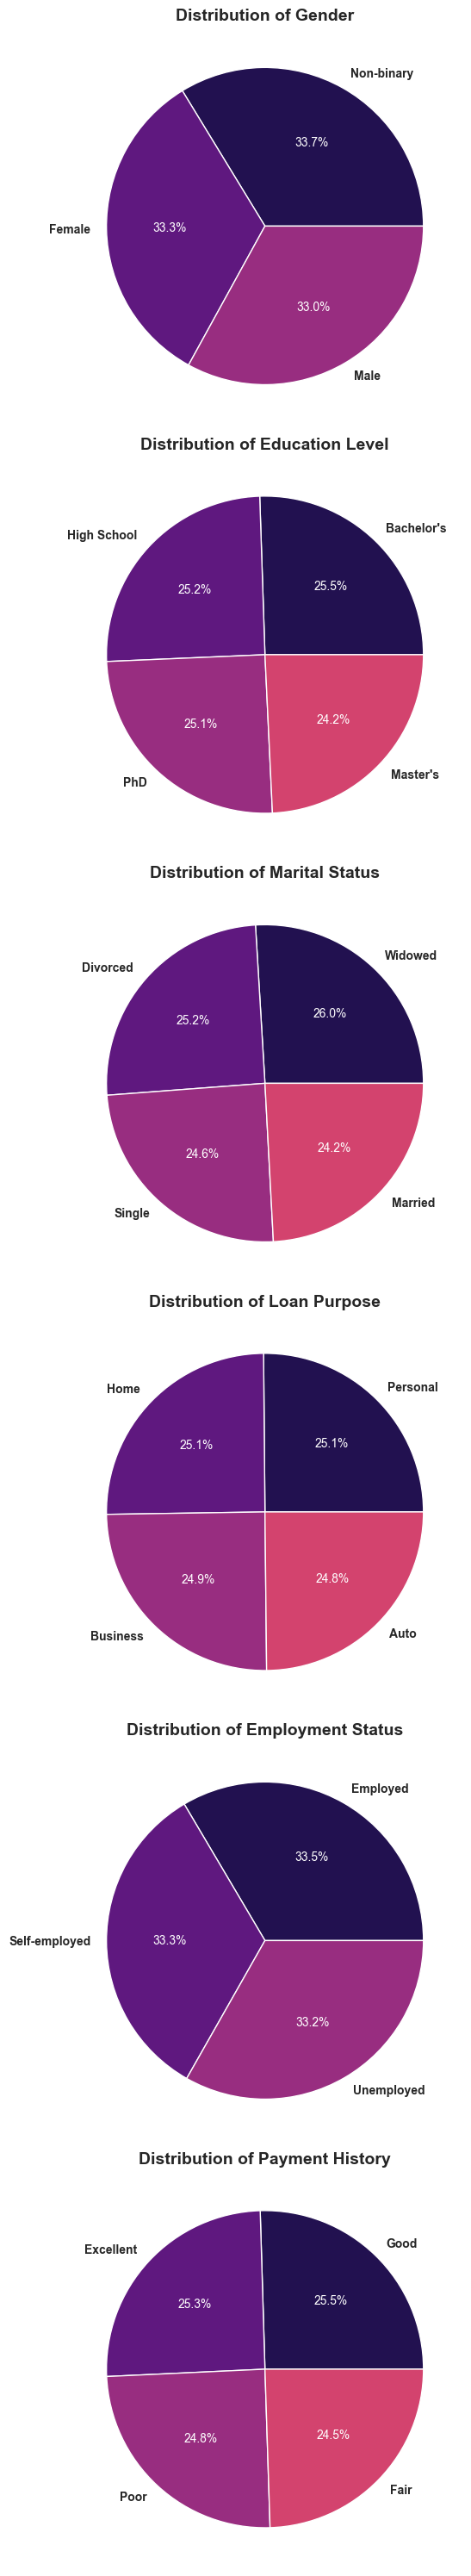

In [9]:
categorical_features = df.select_dtypes(include='object').columns.tolist()
# Selecting categorical features for plotting (excluding high-cardinality ones)
plot_categorical = [col for col in categorical_features if df[col].nunique() < 20 and col != 'Risk Rating']

# Create subplots
fig, axes = plt.subplots(nrows=len(plot_categorical), ncols=1, figsize=(8, len(plot_categorical) * 5))

if len(plot_categorical) == 1:
    axes = [axes]

for i, col in enumerate(plot_categorical):
    show_piechart(col, axes[i])

plt.tight_layout()
plt.show()



Categorical Features (Plotting): ['Gender', 'Education Level', 'Marital Status', 'Loan Purpose', 'Employment Status', 'Payment History']


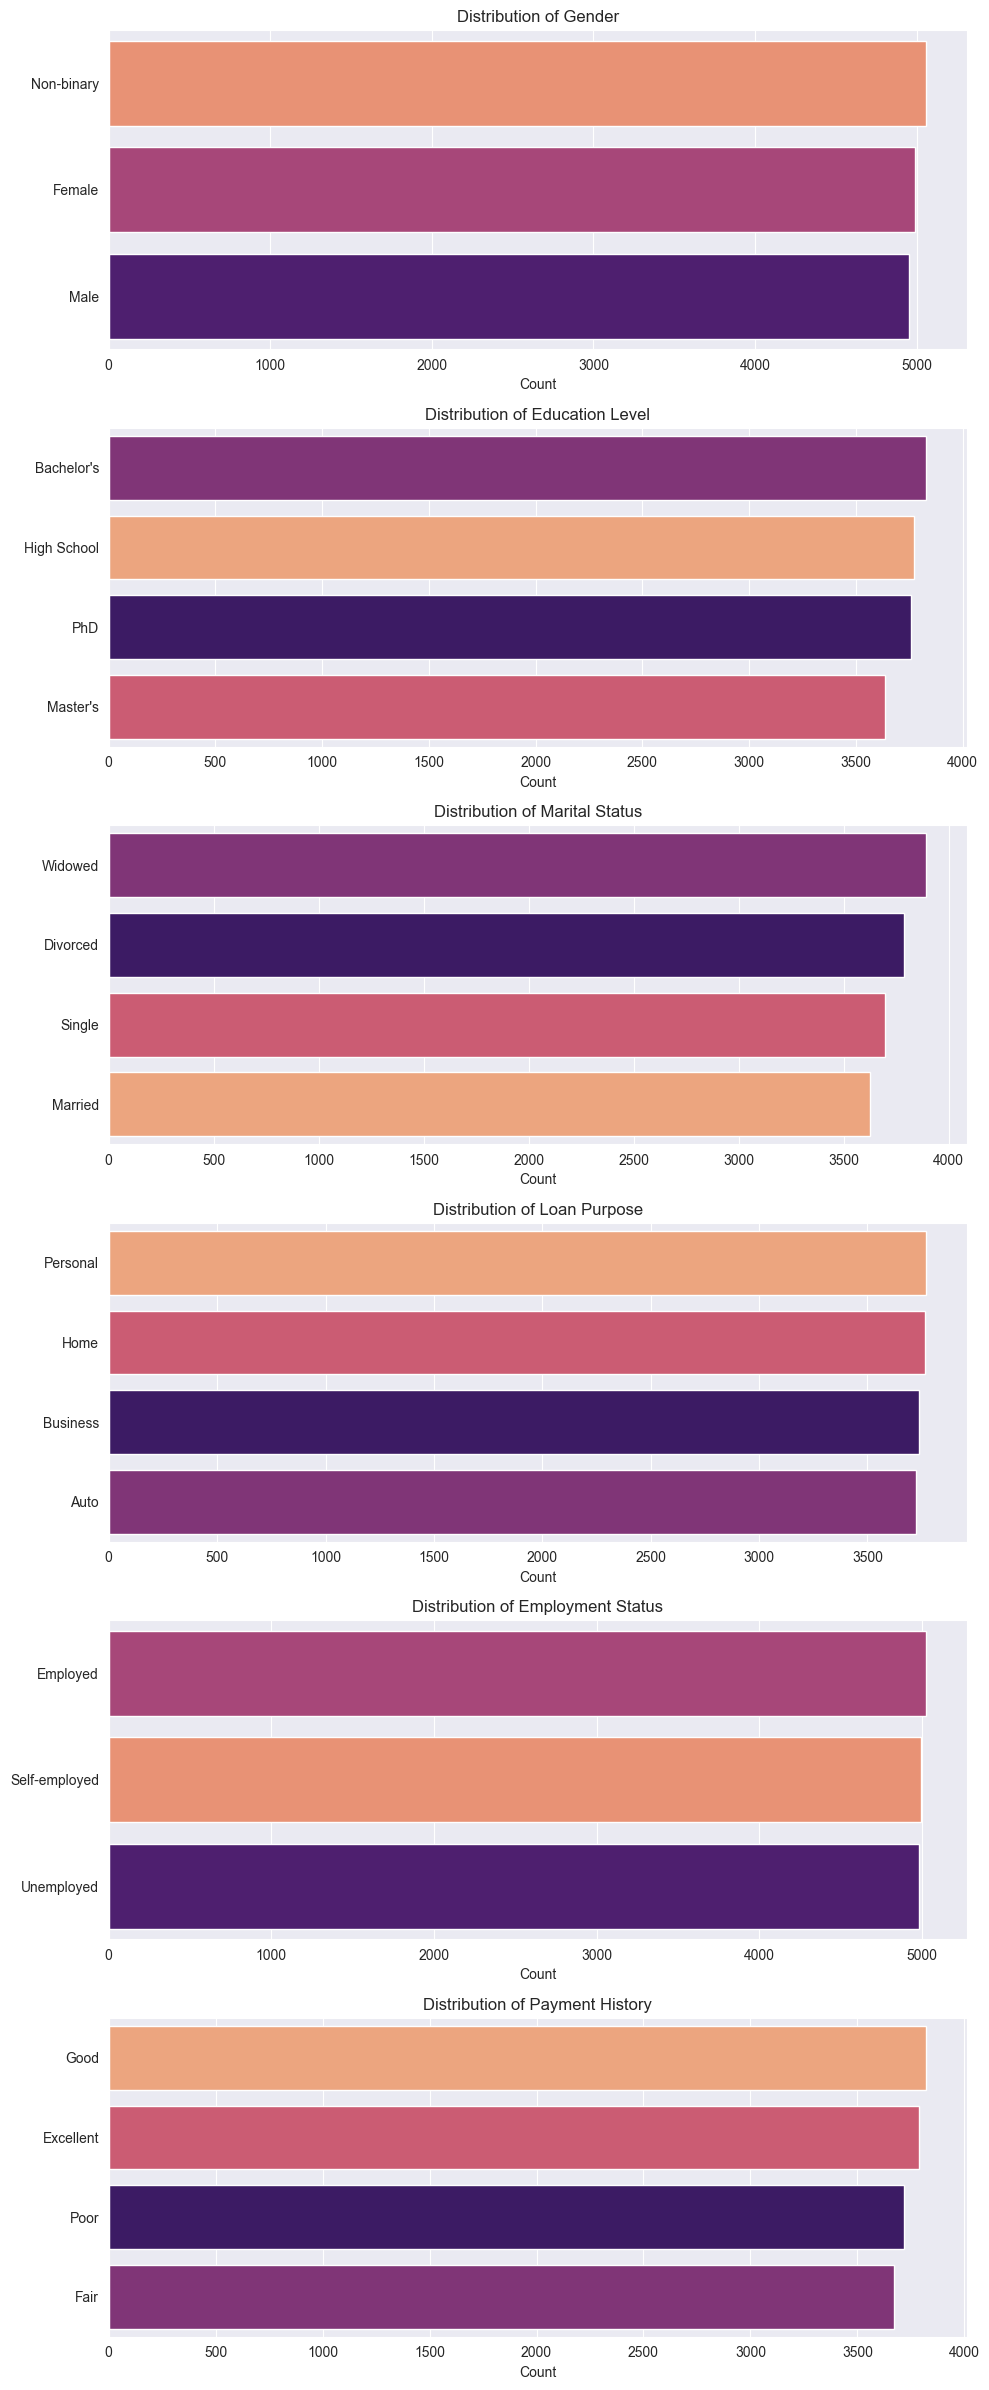

In [10]:
# --- Categorical Feature Distributions ---
categorical_features = df.select_dtypes(include='object').columns.tolist()
plot_categorical = [col for col in categorical_features if df[col].nunique() < 20 and col != 'Risk Rating']
print(f"\nCategorical Features (Plotting): {plot_categorical}")

fig, axes = plt.subplots(nrows=len(plot_categorical), ncols=1, figsize=(10, len(plot_categorical) * 4))
if len(plot_categorical) == 1:
    axes = [axes]
for i, col in enumerate(plot_categorical):
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, ax=axes[i], palette='magma', hue=col, legend=False)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

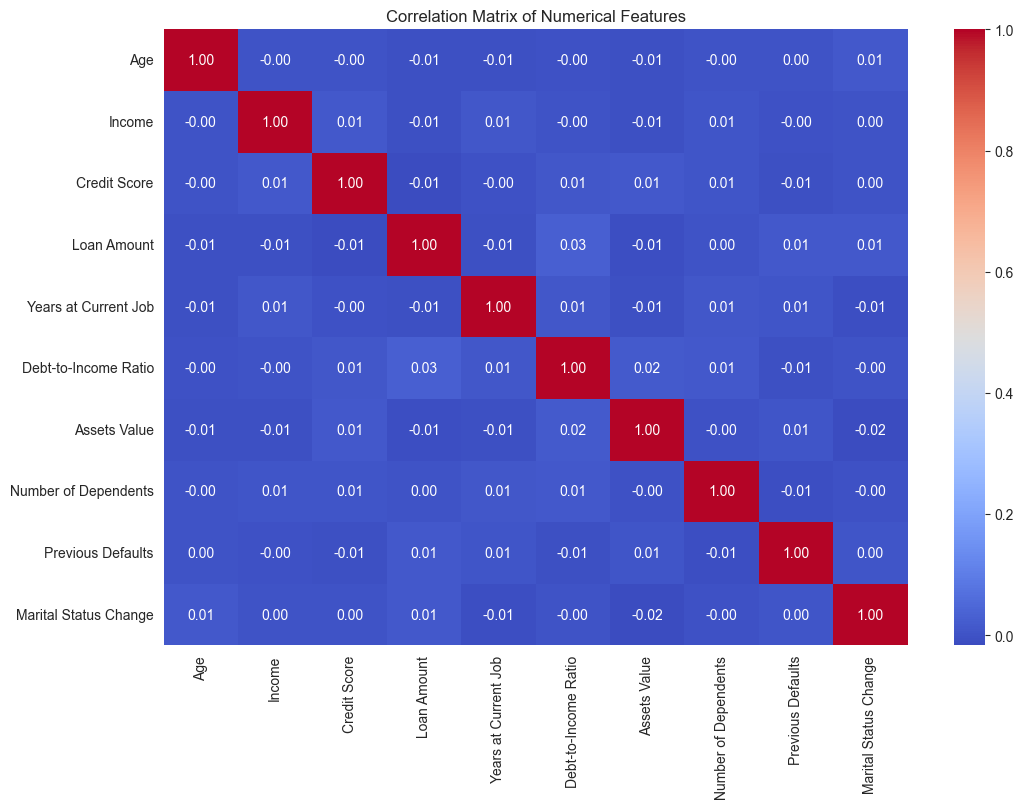

In [11]:
# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Part 1 - Data Preprocessing

* **Explanation:** Prepare the data for the ID3 algorithm. This involves:
    1.  **Handling Missing Values:** Identify columns with missing data and choose a strategy (e.g., imputation with mean/median/mode, dropping rows/columns if appropriate). *Crucially, explain the logic behind your chosen method in comments.* Implement this yourself using Pandas/NumPy.
    2.  **Encoding Categorical Features:** Convert categorical string values into a numerical format suitable for the ID3 algorithm. Common methods include One-Hot Encoding or Label Encoding. *Implement the chosen encoding method yourself using Pandas/NumPy.* Avoid using Scikit-Learn encoders here.
    3.  **Handling Numerical Features (Optional for basic ID3):** Standard ID3 works directly with discrete features. If you adapt ID3 to handle continuous features (e.g., by finding optimal split points), implement that logic here. Basic ID3 might require discretizing continuous features first (e.g., binning). Implement discretization yourself if needed.
    4.  **Feature Selection/Dropping:** Decide if any columns should be dropped (e.g., identifiers, high cardinality features like 'City' if not handled properly, features deemed irrelevant).
    *Remember to perform these operations without external libraries like Scikit-Learn's preprocessors, as per the assignment constraints (NumPy and Pandas functions are allowed).* Make a copy of the dataframe before preprocessing if you want to keep the original.

In [122]:
# --- Missing Values Distributions ---

missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Print missing value count
print("\nMissing Values Before Handling:\n")
print(missing_values.sort_values(ascending=False))



Missing Values Before Handling:

Income                  2250
Credit Score            2250
Loan Amount             2250
Assets Value            2250
Number of Dependents    2250
Previous Defaults       2250
dtype: int64


In [123]:
# deep copy
df_processed = df.copy()

# Strategy: Impute numerical with median, categorical with mode
# Justification: Median is robust to outliers for numerical data.
# Mode is suitable for categorical data.

print("\nMissing values handling:")
for col in df_processed.columns:
    if df_processed[col].isnull().any():
        if pd.api.types.is_numeric_dtype(df_processed[col]):
            # Impute numerical columns with median
            median_val = df_processed[col].median()
            df_processed[col].fillna(median_val, inplace=True)
            print(f"Imputed numerical column '{col}' with median: {median_val}")
        elif pd.api.types.is_object_dtype(df_processed[col]):
            # Impute categorical columns with mode
            mode_val = df_processed[col].mode()[0] # mode() can return multiple values
            df_processed[col].fillna(mode_val, inplace=True)
            print(f"Imputed categorical column '{col}' with mode: {mode_val}")

print("\nMissing values after handling:")
print(f"Handling operation {'succes' if df_processed.isnull().sum().sum() == 0 else 'failed'}!")



Missing values handling:
Imputed numerical column 'Income' with median: 69773.0
Imputed numerical column 'Credit Score' with median: 699.0
Imputed numerical column 'Loan Amount' with median: 27544.0
Imputed numerical column 'Assets Value' with median: 159362.0
Imputed numerical column 'Number of Dependents' with median: 2.0
Imputed numerical column 'Previous Defaults' with median: 2.0

Missing values after handling:
Handling operation succes!


In [124]:

# --- Encode Categorical Features ---
# Strategy: Use Pandas get_dummies (One-Hot Encoding) - This uses Pandas functions, which is allowed.
# Alternatively, implement Label Encoding or One-Hot Encoding manually.
categorical_cols = df_processed.select_dtypes(include='object').columns

# If using Label Encoding (implement manually or carefully with factorize):
# label_maps = {}
# for col in categorical_cols:
#     df_processed[col], unique_labels = pd.factorize(df_processed[col])
#     label_maps[col] = {i: label for i, label in enumerate(unique_labels)}
#     print(f"Label encoded '{col}'. Mapping: {label_maps[col]}")
# If using One-Hot Encoding with Pandas get_dummies:

categorical_to_encode = [col for col in categorical_cols if col != target_col]

# Drop high cardinality features before OHE if necessary
drop_columns = {'City', 'State', 'Country'}
matched_drop_columns = drop_columns.intersection(categorical_to_encode)
for col in matched_drop_columns:
    print(f"Dropping '{col}' due to high cardinality before One-Hot Encoding.")
    df_processed.drop(col, axis=1, inplace=True)
    categorical_to_encode.remove(col)
if categorical_to_encode: # Check if list is not empty
    df_processed = pd.get_dummies(df_processed, columns=categorical_to_encode, drop_first=False) # drop_first=False for standard ID3
    print(f"\nApplied One-Hot Encoding to: {categorical_to_encode}")
    print("New shape after OHE:", df_processed.shape)
    print("New Columns:", sorted(set(df_processed.columns) - set(df.columns)))

Dropping 'City' due to high cardinality before One-Hot Encoding.
Dropping 'Country' due to high cardinality before One-Hot Encoding.
Dropping 'State' due to high cardinality before One-Hot Encoding.

Applied One-Hot Encoding to: ['Gender', 'Education Level', 'Marital Status', 'Loan Purpose', 'Employment Status', 'Payment History']
New shape after OHE: (15000, 33)
New Columns: ["Education Level_Bachelor's", 'Education Level_High School', "Education Level_Master's", 'Education Level_PhD', 'Employment Status_Employed', 'Employment Status_Self-employed', 'Employment Status_Unemployed', 'Gender_Female', 'Gender_Male', 'Gender_Non-binary', 'Loan Purpose_Auto', 'Loan Purpose_Business', 'Loan Purpose_Home', 'Loan Purpose_Personal', 'Marital Status_Divorced', 'Marital Status_Married', 'Marital Status_Single', 'Marital Status_Widowed', 'Payment History_Excellent', 'Payment History_Fair', 'Payment History_Good', 'Payment History_Poor']


In [ ]:
# --- 3. Handle Numerical Features (Discretization if needed) ---
# Example: Discretize 'Age' into bins (implement manually)
# age_bins = [0, 30, 40, 50, 60, 100]
# age_labels = ['0-30', '31-40', '41-50', '51-60', '60+']
# df_processed['Age_Group'] = pd.cut(df_processed['Age'], bins=age_bins, labels=age_labels, right=False)
# df_processed.drop('Age', axis=1, inplace=True) # Drop original continuous column
# print("\nDiscretized 'Age' into 'Age_Group'.")
# --- Apply similar discretization to other continuous features if your ID3 implementation requires it ---
# --- 4. Feature Selection/Dropping (if any others) ---
# Example: Drop features deemed irrelevant after exploration
# cols_to_drop = ['Some_Irrelevant_Column']
# df_processed.drop(cols_to_drop, axis=1, inplace=True, errors='ignore')

In [125]:
# End of preprocces
print("\nPreprocessing complete. Final columns:")
print(df_processed.columns)
print("\nProcessed DataFrame head:")
print(df_processed.head())


Preprocessing complete. Final columns:
Index(['Age', 'Income', 'Credit Score', 'Loan Amount', 'Years at Current Job',
       'Debt-to-Income Ratio', 'Assets Value', 'Number of Dependents',
       'Previous Defaults', 'Marital Status Change', 'Risk Rating',
       'Gender_Female', 'Gender_Male', 'Gender_Non-binary',
       'Education Level_Bachelor's', 'Education Level_High School',
       'Education Level_Master's', 'Education Level_PhD',
       'Marital Status_Divorced', 'Marital Status_Married',
       'Marital Status_Single', 'Marital Status_Widowed', 'Loan Purpose_Auto',
       'Loan Purpose_Business', 'Loan Purpose_Home', 'Loan Purpose_Personal',
       'Employment Status_Employed', 'Employment Status_Self-employed',
       'Employment Status_Unemployed', 'Payment History_Excellent',
       'Payment History_Fair', 'Payment History_Good', 'Payment History_Poor'],
      dtype='object')

Processed DataFrame head:
   Age   Income  Credit Score  Loan Amount  Years at Current Job  \
0 

## Part 1 - Data Splitting

* **Explanation:** Separate the features (X) from the target variable (y). Then, split the data into training (70%), validation (15%), and test (15%) sets. Use the `train_test_split` function from Scikit-Learn (this is explicitly allowed). Ensure the split is random and stratified (to maintain target class proportions) for classification tasks. Use a fixed `random_state` for reproducibility.

In [135]:

# Separate features (X) and the target variable (y)
target_col = 'Risk Rating'
X = df_processed.drop(target_col, axis=1)
y = df_processed[target_col]


# Separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
        
# Separate train (70% of original) and validation (15% of original)
# Validation size relative to the remaining data (85%)
val_size_relative = 0.15 / (1.0 - 0.15) # 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size_relative, random_state=42, stratify=y_temp)

print("Data Splitting Complete:")
print(f"  Training Set Shape: X={X_train.shape}, y={y_train.shape}")
print(f"  Validation Set Shape: X={X_val.shape}, y={y_val.shape}")
print(f"  Test Set Shape: X={X_test.shape}, y={y_test.shape}")

print("\nTarget distribution in each set:")
print("------------------")
print("Train:")
print(y_train.value_counts(normalize=True).sort_index())
print("------------------")
print("Validation:")
print(y_val.value_counts(normalize=True).sort_index())
print("------------------")
print("Test:")
print(y_test.value_counts(normalize=True).sort_index())

Data Splitting Complete:
  Training Set Shape: X=(10500, 32), y=(10500,)
  Validation Set Shape: X=(2250, 32), y=(2250,)
  Test Set Shape: X=(2250, 32), y=(2250,)

Target distribution in each set:
------------------
Train:
Risk Rating
High      0.1
Low       0.6
Medium    0.3
Name: proportion, dtype: float64
------------------
Validation:
Risk Rating
High      0.1
Low       0.6
Medium    0.3
Name: proportion, dtype: float64
------------------
Test:
Risk Rating
High      0.1
Low       0.6
Medium    0.3
Name: proportion, dtype: float64


## Part 1 - ID3 Algorithm Implementation

* **Explanation:** Implement the core logic of the ID3 algorithm *from scratch*. This involves creating functions for:
    1.  `calculate_entropy(data_subset)`: Computes the entropy of a subset of data based on the target variable distribution.
    2.  `calculate_information_gain(full_data, attribute, target_name)`: Computes the information gain achieved by splitting the data on a specific attribute.
    3.  `find_best_attribute(data, features, target_name)`: Iterates through available features, calculates information gain for each, and returns the feature with the highest gain.
    4.  `build_id3_tree(...)`: The main recursive function that builds the tree. It handles base cases (e.g., all samples belong to one class, no features left, max depth reached) and recursive calls for subtrees.
    * Consider using a dictionary or a simple class to represent tree nodes (storing the splitting attribute, children nodes, and leaf value if applicable).
    * Handle both categorical and potentially continuous features (if you implemented discretization or a split-point finding mechanism in preprocessing/ID3).
    * Add parameters like `max_depth` to control tree complexity and test variations.

In [ ]:
# --- Helper Function: Calculate Entropy ---
def calculate_entropy(data_subset, target_name):
    """Calculates the entropy of a dataset subset based on the target variable."""
    entropy = 0.0
    total_samples = len(data_subset)
    if total_samples == 0:
        return 0 # Entropy is 0 for an empty set

    counts = data_subset[target_name].value_counts()
    for count in counts:
        probability = count / total_samples
        if probability > 0: # Avoid log2(0)
            entropy -= probability * math.log2(probability)
    return entropy

# --- Helper Function: Calculate Information Gain ---
def calculate_information_gain(full_data, attribute, target_name):
    """Calculates the information gain of splitting the data on a given attribute."""
    total_samples = len(full_data)
    if total_samples == 0:
        return 0

    # Calculate entropy of the full dataset (parent entropy)
    parent_entropy = calculate_entropy(full_data, target_name)

    # Calculate weighted average entropy of children nodes
    weighted_child_entropy = 0.0
    unique_values = full_data[attribute].unique()

    for value in unique_values:
        subset = full_data[full_data[attribute] == value]
        subset_entropy = calculate_entropy(subset, target_name)
        subset_weight = len(subset) / total_samples
        weighted_child_entropy += subset_weight * subset_entropy

    # Information Gain = Parent Entropy - Weighted Child Entropy
    information_gain = parent_entropy - weighted_child_entropy
    return information_gain

# --- Helper Function: Find Best Attribute to Split On ---
def find_best_attribute(data, features, target_name):
    """Finds the attribute with the highest information gain."""
    best_attribute = None
    max_info_gain = -1 # Initialize with a value lower than any possible gain

    for attribute in features:
        info_gain = calculate_information_gain(data, attribute, target_name)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_attribute = attribute

    return best_attribute

# --- Core Function: Build ID3 Tree Recursively ---
def build_id3_tree(data, original_data, features, target_name, parent_node_class=None, current_depth=0, max_depth=None):
    """Builds the decision tree using the ID3 algorithm recursively."""

    # --- Base Cases ---
    # 1. If all target values are the same, return this value (leaf node)
    if len(data[target_name].unique()) <= 1:
        return data[target_name].iloc[0]

    # 2. If data is empty, return the majority class of the original data
    elif len(data) == 0:
        return original_data[target_name].mode()[0]

    # 3. If no features left to split on, return the majority class of the current node's data
    elif len(features) == 0:
        return data[target_name].mode()[0]

    # 4. If max_depth is specified and reached, return majority class
    elif max_depth is not None and current_depth >= max_depth:
         return data[target_name].mode()[0]

    # --- Recursive Step ---
    else:
        # Determine the majority class for this node (used if we can't split further)
        parent_node_class = data[target_name].mode()[0]

        # Find the best attribute to split on
        best_attribute = find_best_attribute(data, features, target_name)

        # If no attribute provides positive information gain, return majority class
        if best_attribute is None or calculate_information_gain(data, best_attribute, target_name) <= 0:
             return data[target_name].mode()[0]

        # Create the tree structure (using a dictionary)
        # The key is the best attribute, the value is another dictionary mapping attribute values to subtrees
        tree = {best_attribute: {}}

        # Remove the best attribute from the list of features for recursive calls
        remaining_features = [f for f in features if f != best_attribute]

        # Grow the tree branches for each value of the best attribute
        for value in data[best_attribute].unique():
            # Split the data based on the current value
            sub_data = data[data[best_attribute] == value]

            # Recursively build the subtree
            subtree = build_id3_tree(sub_data, data, remaining_features, target_name,
                                     parent_node_class, current_depth + 1, max_depth)
            tree[best_attribute][value] = subtree

        return tree

print("ID3 algorithm helper functions defined.")

## Part 1 - Model Training

* **Explanation:** Train the ID3 decision tree model using the prepared training set (`X_train`, `y_train`). Call the `build_id3_tree` function. You might train multiple variations by passing different `max_depth` values or modifying feature sets to compare performance later.

In [ ]:
if 'X_train' in locals():
    # Combine X_train and y_train for the build_id3_tree function
    train_data = X_train.join(y_train)
    features = list(X_train.columns)
    target = y_train.name

    # Train the ID3 model (example: no max_depth)
    print("Training ID3 model (no max_depth)...")
    id3_tree_model_full = build_id3_tree(train_data, train_data, features, target, max_depth=None)
    print("Training complete (full tree).")

    # Example: Train another model with max_depth=5
    # print("\nTraining ID3 model (max_depth=5)...")
    # id3_tree_model_depth5 = build_id3_tree(train_data, train_data, features, target, max_depth=5)
    # print("Training complete (max_depth=5).")

    # You can store the trained tree(s) for later use
    # print("\nStructure of the full tree (first level):", list(id3_tree_model_full.keys()) if isinstance(id3_tree_model_full, dict) else id3_tree_model_full)

else:
    print("Cannot train model as training data is not available.")

## Part 1 - Prediction Function

* **Explanation:** Implement function(s) to make predictions using the trained ID3 tree. A `predict_sample` function will take a single data instance (e.g., a row from the test set) and traverse the tree according to its attribute values until it reaches a leaf node (prediction). A `predict_batch` function can then iterate over multiple samples.

In [ ]:
def predict_sample(tree, sample):
    """Predicts the class label for a single sample using the trained ID3 tree."""
    # If the current node is not a dictionary, it's a leaf node (prediction)
    if not isinstance(tree, dict):
        return tree

    # Get the splitting attribute for the current node
    attribute = list(tree.keys())[0]
    subtree_dict = tree[attribute]

    # Get the value of the splitting attribute in the sample
    sample_value = sample.get(attribute)

    # If the sample's value for the attribute exists as a branch in the tree
    if sample_value in subtree_dict:
        # Recursively call predict on the corresponding subtree
        return predict_sample(subtree_dict[sample_value], sample)
    else:
        # Handle unseen values during prediction (e.g., return majority class from this level or a default)
        # A simple approach: return the most common prediction among the branches
        # This part might need refinement based on how robust you want the prediction to be
        all_leaf_values = []
        def collect_leaf_values(node):
            if not isinstance(node, dict):
                all_leaf_values.append(node)
                return
            attr = list(node.keys())[0]
            for val in node[attr]:
                collect_leaf_values(node[attr][val])
        collect_leaf_values(tree)
        if not all_leaf_values:
             return None # Should not happen in a well-formed tree
        return Counter(all_leaf_values).most_common(1)[0][0]


def predict_batch(tree, data):
    """Predicts class labels for multiple samples in a DataFrame."""
    # Convert DataFrame rows to dictionaries for easier access in predict_sample
    samples = data.to_dict(orient='records')
    predictions = [predict_sample(tree, sample) for sample in samples]
    return predictions

print("Prediction functions defined.")

## Part 1 - Prediction on Test Set

* **Explanation:** Use the trained ID3 model(s) and the `predict_batch` function to generate predictions for the unseen test set (`X_test`).

In [ ]:
if 'id3_tree_model_full' in locals() and 'X_test' in locals():
    print("Making predictions on the test set using the full tree...")
    test_predictions_full = predict_batch(id3_tree_model_full, X_test)
    print(f"Generated {len(test_predictions_full)} predictions.")
    # print("First 10 predictions:", test_predictions_full[:10])

    # If you trained other models (e.g., depth-limited):
    # if 'id3_tree_model_depth5' in locals():
    #     print("\nMaking predictions on the test set using the max_depth=5 tree...")
    #     test_predictions_depth5 = predict_batch(id3_tree_model_depth5, X_test)
    #     print(f"Generated {len(test_predictions_depth5)} predictions.")
else:
    print("Cannot make predictions as the model or test data is not available.")

## Part 1 - Evaluation Metrics Implementation

* **Explanation:** Implement functions *from scratch* to calculate the required evaluation metrics: Accuracy, Precision, Recall, and F1-Score. These functions will take the true labels (`y_true`) and predicted labels (`y_pred`) as input. For multi-class problems (Low, Medium, High risk), you'll need to decide on an averaging strategy (e.g., macro, weighted) or calculate metrics per class and then average. The assignment formulas are for binary cases, so adapt them or calculate TP/FP/FN per class for multi-class metrics.
* **Accuracy:** (TP + TN) / (TP + TN + FP + FN) -> For multi-class: (Sum of correctly classified samples) / (Total samples)
* **Precision (per class):** TP / (TP + FP)
* **Recall (per class):** TP / (TP + FN)
* **F1-Score (per class):** 2 * (Precision * Recall) / (Precision + Recall)
* **Averaging:** Calculate metrics for each class, then average (e.g., 'macro' average = unweighted mean; 'weighted' average = mean weighted by class support).
* You can use `sklearn.metrics.confusion_matrix` *only* for displaying the matrix or verifying your manual TP/FP/FN calculations, as suggested in the assignment ('obtain a confusion matrix from Scikit-Learn'). Your primary reported metrics should come from your own implementation.

In [ ]:
from collections import defaultdict
from sklearn.metrics import confusion_matrix # Allowed for display/verification

def calculate_metrics(y_true, y_pred, labels=None):
    """Calculates Accuracy, Precision, Recall, F1-Score (macro and weighted)."""
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))
    
    num_classes = len(labels)
    total_samples = len(y_true)
    
    # --- Calculate TP, FP, FN per class ---
    tp = defaultdict(int)
    fp = defaultdict(int)
    fn = defaultdict(int)
    correct_predictions = 0
    
    for i in range(total_samples):
        true_label = y_true[i]
        pred_label = y_pred[i]
        
        if true_label == pred_label:
            correct_predictions += 1
            tp[true_label] += 1
        else:
            fp[pred_label] += 1
            fn[true_label] += 1
            
    # --- Overall Accuracy ---
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    
    # --- Per-class and Averaged Metrics ---
    precision_per_class = {}
    recall_per_class = {}
    f1_per_class = {}
    support_per_class = Counter(y_true)
    
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1 = 0.0
    weighted_precision = 0.0
    weighted_recall = 0.0
    weighted_f1 = 0.0
    
    for label in labels:
        tp_class = tp[label]
        fp_class = fp[label]
        fn_class = fn[label]
        support = support_per_class[label]
        
        # Precision
        precision = tp_class / (tp_class + fp_class) if (tp_class + fp_class) > 0 else 0
        precision_per_class[label] = precision
        macro_precision += precision
        weighted_precision += precision * support
        
        # Recall
        recall = tp_class / (tp_class + fn_class) if (tp_class + fn_class) > 0 else 0
        recall_per_class[label] = recall
        macro_recall += recall
        weighted_recall += recall * support
        
        # F1-Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_per_class[label] = f1
        macro_f1 += f1
        weighted_f1 += f1 * support
        
    # Final Averages
    if num_classes > 0:
        macro_precision /= num_classes
        macro_recall /= num_classes
        macro_f1 /= num_classes
    if total_samples > 0:
        weighted_precision /= total_samples
        weighted_recall /= total_samples
        weighted_f1 /= total_samples
        
    metrics = {
        'accuracy': accuracy,
        'precision_macro': macro_precision,
        'recall_macro': macro_recall,
        'f1_macro': macro_f1,
        'precision_weighted': weighted_precision,
        'recall_weighted': weighted_recall,
        'f1_weighted': weighted_f1,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'support_per_class': dict(support_per_class)
    }
    
    return metrics

print("Evaluation metric functions defined.")

# Example usage (after getting predictions):
# true_labels = y_test.tolist()
# pred_labels = test_predictions_full
# results = calculate_metrics(true_labels, pred_labels)
# print(results)

## Part 1 - Model Evaluation & Comparison

* **Explanation:** Evaluate the performance of your trained ID3 model(s) on the **test set** using the metrics implemented in the previous cell. 
    * Calculate and print Accuracy, Precision (macro/weighted), Recall (macro/weighted), and F1-Score (macro/weighted).
    * If you trained multiple model variations (e.g., different `max_depth`), present their results in a clear format (like a table) for comparison.
    * Display the confusion matrix (using `sklearn.metrics.confusion_matrix` is acceptable here for visualization/verification).
    * Discuss the results. Which model performed best on the test set? Is there evidence of overfitting (high train accuracy, lower test accuracy)? Discuss any trade-offs observed (e.g., a deeper tree might take longer to train/predict but achieve higher accuracy, or it might overfit).

In [ ]:
if 'test_predictions_full' in locals() and 'y_test' in locals():
    print("--- Evaluating Full ID3 Tree (No Max Depth) on Test Set ---")
    true_labels_test = y_test.tolist()
    pred_labels_test_full = test_predictions_full
    
    # Ensure labels are consistent if some classes are missing in predictions
    all_labels = sorted(list(set(true_labels_test) | set(pred_labels_test_full)))

    # Calculate metrics using your function
    metrics_full = calculate_metrics(true_labels_test, pred_labels_test_full, labels=all_labels)

    print(f"Accuracy: {metrics_full['accuracy']:.4f}")
    print(f"Precision (Macro): {metrics_full['precision_macro']:.4f}")
    print(f"Recall (Macro): {metrics_full['recall_macro']:.4f}")
    print(f"F1-Score (Macro): {metrics_full['f1_macro']:.4f}")
    print(f"Precision (Weighted): {metrics_full['precision_weighted']:.4f}")
    print(f"Recall (Weighted): {metrics_full['recall_weighted']:.4f}")
    print(f"F1-Score (Weighted): {metrics_full['f1_weighted']:.4f}")

    print("\nMetrics per class:")
    for label in all_labels:
        print(f"  Class: {label}")
        print(f"    Precision: {metrics_full['precision_per_class'].get(label, 0):.4f}")
        print(f"    Recall:    {metrics_full['recall_per_class'].get(label, 0):.4f}")
        print(f"    F1-Score:  {metrics_full['f1_per_class'].get(label, 0):.4f}")
        print(f"    Support:   {metrics_full['support_per_class'].get(label, 0)}")

    # Display Confusion Matrix (using sklearn for visualization)
    cm = confusion_matrix(true_labels_test, pred_labels_test_full, labels=all_labels)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Full Tree (Test Set)')
    plt.show()

    # --- Add evaluation for other model variations if you created them ---
    # Example:
    # if 'test_predictions_depth5' in locals():
    #     print("\n--- Evaluating ID3 Tree (Max Depth=5) on Test Set ---")
    #     pred_labels_test_depth5 = test_predictions_depth5
    #     metrics_depth5 = calculate_metrics(true_labels_test, pred_labels_test_depth5, labels=all_labels)
    #     # ... print metrics for depth 5 model ...
    #     cm_depth5 = confusion_matrix(true_labels_test, pred_labels_test_depth5, labels=all_labels)
    #     # ... plot confusion matrix for depth 5 model ...

    # --- Discussion ---
    print("\nDiscussion:")
    print("- Compare the performance of different variations (if any). Did limiting depth help?")
    print("- Comment on potential overfitting (compare with training accuracy if calculated). The full tree might overfit.")
    print("- Discuss the trade-off between complexity/computation and performance.")

else:
    print("Cannot evaluate model as predictions or true test labels are not available.")

## Part 1 - Rule Extraction

* **Explanation:** Implement a function to traverse your *best performing* decision tree model (based on test set evaluation) and print out the decision rules. Each rule corresponds to a path from the root node to a leaf node. The output should clearly show the conditions (attribute values) along the path and the final predicted class at the leaf. Print paths in left-to-right order (which usually happens naturally with recursive traversal).

In [ ]:
def print_tree_rules(node, path_str="IF ", indent="  "):
    """Recursively prints the rules of the decision tree."""
    # Base case: If node is a leaf (prediction)
    if not isinstance(node, dict):
        # Remove the last ' AND ' from the path string
        final_path = path_str[:-5] if path_str.endswith(" AND ") else path_str
        print(f"{final_path} THEN Risk Rating = {node}")
        return

    # Recursive step: If node is an internal node (split)
    attribute = list(node.keys())[0]
    value_dict = node[attribute]

    # Iterate through branches (values of the attribute)
    for value, subtree in value_dict.items():
        # Construct the condition string for this branch
        condition = f"{attribute} == {value}"
        # Recursively call for the subtree
        print_tree_rules(subtree, path_str + condition + " AND ", indent + "  ")

# --- Select the best tree model based on evaluation ---
# Assuming id3_tree_model_full is the one we want rules for (or choose another)
best_tree_model = None
if 'id3_tree_model_full' in locals(): # Choose your best model here
     best_tree_model = id3_tree_model_full
     # Example: if you had a depth 5 model and it performed better:
     # best_tree_model = id3_tree_model_depth5

if best_tree_model:
    print("--- Rules for the Selected Decision Tree Model ---")
    if isinstance(best_tree_model, dict):
        print_tree_rules(best_tree_model)
    else:
        # Handle the case where the tree is just a single leaf node (e.g., if training data was pure)
        print(f"The tree is a single leaf node predicting: {best_tree_model}")
else:
    print("Cannot extract rules as the best tree model is not available or defined.")

## Part 1 - Misclassification Analysis

* **Explanation:** Identify a few specific instances from the **test set** that your model misclassified. 
    * Find the indices where the predicted label does not match the true label.
    * Display the features of these misclassified samples (from `X_test`).
    * Show their true `Risk Rating` (from `y_test`) and the incorrect prediction made by your model.
    * Provide comments explaining *why* you think these particular instances might have been hard for the model to classify correctly. Consider factors like unusual feature combinations, borderline cases, potential noise in the data, or limitations of the ID3 algorithm.

In [ ]:
if 'test_predictions_full' in locals() and 'y_test' in locals() and 'X_test' in locals():
    print("--- Misclassification Analysis (Test Set) ---")
    
    true_labels_list = y_test.tolist()
    pred_labels_list = test_predictions_full # Use predictions from your chosen best model
    
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_labels_list, pred_labels_list)) if true != pred]
    
    if not misclassified_indices:
        print("No misclassifications found on the test set. Perfect score!")
    else:
        num_to_show = min(5, len(misclassified_indices)) # Show up to 5 examples
        print(f"Found {len(misclassified_indices)} misclassified samples. Showing first {num_to_show}:")
        
        for i in range(num_to_show):
            idx = misclassified_indices[i]
            original_index = X_test.index[idx] # Get original index if needed
            print(f"\nSample Index (in X_test): {idx} (Original Index: {original_index})")
            print(f"  True Label: {true_labels_list[idx]}")
            print(f"  Predicted Label: {pred_labels_list[idx]}")
            print("  Features:")
            # Print relevant features - adjust which columns are most informative
            print(X_test.iloc[idx]) 
            
            # --- Add your comments here --- 
            print("\n  Comments on Misclassification:")
            print("    [Explain why this sample might have been hard to classify. Consider its features.]")
            print("    [e.g., 'Features seem borderline between Medium and High risk...', 'Unusual combination of high income but poor credit score...']")
            
else:
     print("Cannot perform misclassification analysis as predictions or test data are not available.")

## Part 2 - Pruning Algorithm Implementation

* **Explanation:** Implement the post-pruning algorithm described in the PDF (Reduced Error Pruning variant). This algorithm uses the **validation set** to decide which nodes to prune.
    1.  **Identify Twigs:** Create a function to find all 'twigs' in the tree. A twig is a node whose children are all leaf nodes.
    2.  **Calculate Metric (Accuracy/F1):** You need the `predict_batch` and `calculate_metrics` functions from Part 1 to evaluate the tree's performance on the validation set.
    3.  **Find Least 'Important' Twig:** The PDF suggests pruning the twig with the *least Information Gain*. You might need to store IG during tree building or recalculate it. Alternatively, a common approach for Reduced Error Pruning is to simply try pruning *each* twig temporarily and see which removal results in the *best* (or least detrimental) accuracy on the validation set.
    4.  **Pruning Mechanism:** Implement logic to modify the tree structure: take a twig node, remove its children, and turn it into a leaf node predicting the majority class of the data that reached that node during training.
    5.  **Main Loop:** Implement the iterative process described:
        * Start with the unpruned tree and its accuracy on the validation set (`last_accuracy`).
        * In a loop:
            * Find all twigs in the *current* tree.
            * For each twig, temporarily prune it (turn into majority class leaf).
            * Evaluate the accuracy of this temporarily pruned tree on the validation set.
            * Identify the twig whose removal results in the highest accuracy on the validation set.
            * If this best accuracy (`current_accuracy`) is greater than or equal to `last_accuracy`:
                * Permanently prune that best twig from the tree.
                * Update `last_accuracy = current_accuracy`.
                * Continue the loop.
            * Else (no twig removal improves or maintains accuracy):
                * Stop the pruning process. The tree from the *previous* iteration is the final pruned tree.
    * **Important:** Use `copy.deepcopy()` to create copies of the tree before temporary pruning or before starting the main loop, so you can revert changes or keep the original tree intact.
    * Consider the optional enhancements: using F1-score instead of accuracy, or keeping track of the last 'n' versions.

In [ ]:
def get_twigs(tree):
    """Finds all twig nodes in the tree. Returns a list of paths to the twigs."""
    twigs = []
    def find_twigs_recursive(node, path):
        if not isinstance(node, dict): # Leaf node
            return False # Not a twig itself

        attribute = list(node.keys())[0]
        is_twig = True
        for value, subtree in node[attribute].items():
            # If any child is not a leaf, this node is not a twig
            if isinstance(subtree, dict):
                is_twig = False
                # Continue searching deeper
                find_twigs_recursive(subtree, path + [(attribute, value)])
        
        if is_twig:
            twigs.append(path)
            
    find_twigs_recursive(tree, [])
    return twigs

def get_node_by_path(tree, path):
    """Accesses a node in the tree using its path."""
    node = tree
    for attr, val in path:
        if isinstance(node, dict) and attr in node and val in node[attr]:
             node = node[attr][val]
        else:
            return None # Path invalid
    return node

def set_node_by_path(tree, path, new_node):
    """Sets a node in the tree using its path."""
    if not path: # Setting the root
        # This case needs careful handling depending on how you store the tree root
        # For a simple dict, directly modifying might be tricky. Usually prune internal nodes.
        print("Warning: Attempting to prune the root node directly.")
        return False 
        
    parent_node = tree
    for i in range(len(path) - 1):
        attr, val = path[i]
        if isinstance(parent_node, dict) and attr in parent_node and val in parent_node[attr]:
             parent_node = parent_node[attr][val]
        else:
            print(f"Error: Invalid path segment during set_node: {path[i]}")
            return False # Path invalid
            
    # Now parent_node is the parent of the node to be replaced
    final_attr, final_val = path[-1]
    if isinstance(parent_node, dict) and final_attr in parent_node and final_val in parent_node[final_attr]:
        parent_node[final_attr][final_val] = new_node
        return True
    else:
        print(f"Error: Cannot set node at final path segment: {path[-1]}")
        return False

def get_majority_class(tree_node, data_subset):
    """Finds the majority class in the data subset that reaches a node."""
    # This is tricky without passing data down. A simpler approach for pruning:
    # Use the majority class of the LEAVES under the twig being pruned.
    if not isinstance(tree_node, dict):
        return tree_node # Should not happen if called on a twig parent
    
    leaf_values = []
    attribute = list(tree_node.keys())[0]
    for value, subtree in tree_node[attribute].items():
        if not isinstance(subtree, dict):
            leaf_values.append(subtree)
        # else: This function assumes the input node is a twig parent
            
    if not leaf_values:
        # Fallback: If somehow called on a non-twig or empty branch
        # This might indicate an issue elsewhere. Returning None or raising error?
        print("Warning: get_majority_class called on unexpected node structure.")
        return None 
        
    return Counter(leaf_values).most_common(1)[0][0]

print("Pruning helper functions defined.")

## Part 2 - Execute Pruning

* **Explanation:** Apply the implemented pruning algorithm.
    1.  Select the initial tree to prune (usually the best performing unpruned tree from Part 1).
    2.  Make a deep copy of this tree using `copy.deepcopy()`.
    3.  Calculate the initial accuracy (or F1-score) of this tree on the **validation set** (`X_val`, `y_val`). This is `last_accuracy`.
    4.  Start the pruning loop:
        * Find all twigs in the current `pruned_tree`.
        * If no twigs are left, stop.
        * Keep track of the best accuracy found in this iteration and which twig removal achieved it.
        * Iterate through each twig path found:
            * Make a temporary copy of the `pruned_tree`.
            * Get the node corresponding to the twig path.
            * Determine the majority class for this twig (e.g., based on its leaf children).
            * Modify the temporary tree by replacing the twig node with the majority class leaf using `set_node_by_path`.
            * Calculate the accuracy of this `temp_pruned_tree` on the validation set.
            * If this accuracy is better than the current best for this iteration, update the best accuracy and store the path of the twig that was removed.
        * After checking all twigs, compare the best accuracy found (`current_best_accuracy_in_iter`) with `last_accuracy`.
        * If `current_best_accuracy_in_iter >= last_accuracy`:
            * Permanently prune the best twig found in this iteration from the main `pruned_tree` (using `set_node_by_path` again on `pruned_tree`).
            * Update `last_accuracy = current_best_accuracy_in_iter`.
            * Print progress (e.g., "Pruned twig at path X, new accuracy: Y").
        * Else (`current_best_accuracy_in_iter < last_accuracy`):
            * Print "No improvement found, stopping pruning."
            * Break the loop.
    5.  The final `pruned_tree` is the result.

In [ ]:
if 'best_tree_model' in locals() and best_tree_model is not None and 'X_val' in locals():
    print("--- Starting Reduced Error Pruning ---")
    
    # 1. Make a deep copy of the tree to prune
    pruned_tree = copy.deepcopy(best_tree_model)
    
    # 2. Calculate initial accuracy on the validation set
    val_true = y_val.tolist()
    initial_val_preds = predict_batch(pruned_tree, X_val)
    initial_metrics = calculate_metrics(val_true, initial_val_preds)
    last_accuracy = initial_metrics['accuracy'] # Or use F1: initial_metrics['f1_weighted']
    print(f"Initial validation accuracy: {last_accuracy:.4f}")
    
    # 3. Pruning Loop
    iteration = 0
    while True:
        iteration += 1
        print(f"\nPruning Iteration {iteration}...")
        
        # Find all twigs in the current tree
        twig_paths = get_twigs(pruned_tree)
        
        if not twig_paths:
            print("No more twigs found to prune.")
            break
            
        print(f"Found {len(twig_paths)} twigs.")
        
        best_accuracy_this_iter = -1.0
        best_twig_path_to_prune = None
        best_pruned_tree_this_iter = None

        # Iterate through each twig to find the best one to prune
        for twig_path in twig_paths:
            # Create a temporary copy for testing this prune
            temp_tree = copy.deepcopy(pruned_tree)
            
            # Get the node (twig's parent) and determine majority class
            node_to_prune = get_node_by_path(temp_tree, twig_path)
            if node_to_prune is None or not isinstance(node_to_prune, dict):
                 # This might happen if path is invalid or points to a leaf already
                 # print(f"Skipping invalid twig path: {twig_path}")
                 continue 
            
            majority_class = get_majority_class(node_to_prune, None) # Pass relevant data if needed by your implementation
            if majority_class is None:
                print(f"Warning: Could not determine majority class for twig at {twig_path}. Skipping.")
                continue
                
            # Prune the temporary tree by replacing the twig node with a leaf
            success = set_node_by_path(temp_tree, twig_path, majority_class)
            
            if not success:
                 print(f"Failed to prune twig at path {twig_path}. Skipping.")
                 continue
            
            # Evaluate this temporarily pruned tree on the validation set
            temp_val_preds = predict_batch(temp_tree, X_val)
            temp_metrics = calculate_metrics(val_true, temp_val_preds)
            current_accuracy = temp_metrics['accuracy'] # Or F1
            
            # Check if this prune is the best one found so far in this iteration
            if current_accuracy > best_accuracy_this_iter:
                best_accuracy_this_iter = current_accuracy
                best_twig_path_to_prune = twig_path
                # Keep a reference to the tree state after the best prune of this iteration
                # best_pruned_tree_this_iter = copy.deepcopy(temp_tree) # Optional: store the best tree directly
                
        # After checking all twigs in this iteration
        print(f"Best accuracy found in iteration {iteration}: {best_accuracy_this_iter:.4f}")
        
        # Compare with the accuracy before this iteration
        if best_twig_path_to_prune is not None and best_accuracy_this_iter >= last_accuracy:
            print(f"Accuracy improved or maintained. Permanently pruning twig at path: {best_twig_path_to_prune}")
            # Permanently prune the best twig from the main pruned_tree
            node_to_prune_final = get_node_by_path(pruned_tree, best_twig_path_to_prune)
            majority_class_final = get_majority_class(node_to_prune_final, None)
            set_node_by_path(pruned_tree, best_twig_path_to_prune, majority_class_final)
            
            # Update last_accuracy
            last_accuracy = best_accuracy_this_iter
            print(f"New validation accuracy: {last_accuracy:.4f}")
        else:
            print("No improvement in accuracy found in this iteration. Stopping pruning.")
            break # Exit the while loop
            
    print("--- Pruning process finished ---")
    final_pruned_tree = pruned_tree

else:
    print("Cannot perform pruning as the initial tree model or validation data is not available.")
    final_pruned_tree = None

## Part 2 - Post-Pruning Evaluation

* **Explanation:** Evaluate the performance of the **final pruned tree** on all three datasets: **training**, **validation**, and **test** sets. Calculate and report Accuracy, Precision, Recall, and F1-Score (macro or weighted) for each set. This allows you to see how pruning affected performance on data it saw during training, data used for pruning decisions, and completely unseen data.

In [ ]:
if 'final_pruned_tree' in locals() and final_pruned_tree is not None:
    print("--- Evaluating Final Pruned Tree ---")
    
    datasets = {
        'Train': (X_train, y_train.tolist()),
        'Validation': (X_val, y_val.tolist()),
        'Test': (X_test, y_test.tolist())
    }
    
    results_pruned = {}
    
    all_labels = sorted(list(set(y_train) | set(y_val) | set(y_test)))

    for name, (X_data, y_true_list) in datasets.items():
        print(f"\nEvaluating on {name} Set...")
        y_pred_list = predict_batch(final_pruned_tree, X_data)
        metrics = calculate_metrics(y_true_list, y_pred_list, labels=all_labels)
        results_pruned[name] = metrics
        
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Precision (Weighted): {metrics['precision_weighted']:.4f}")
        print(f"  Recall (Weighted): {metrics['recall_weighted']:.4f}")
        print(f"  F1-Score (Weighted): {metrics['f1_weighted']:.4f}")
        
        # Optional: Display confusion matrix for the test set
        if name == 'Test':
            cm_pruned = confusion_matrix(y_true_list, y_pred_list, labels=all_labels)
            plt.figure(figsize=(7, 5))
            sns.heatmap(cm_pruned, annot=True, fmt='d', cmap='Greens', xticklabels=all_labels, yticklabels=all_labels)
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title('Confusion Matrix - Pruned Tree (Test Set)')
            plt.show()
else:
    print("Cannot evaluate pruned tree as it is not available.")

## Part 2 - Rule Extraction (Post-Pruning)

* **Explanation:** Use the same rule extraction function developed in Part 1 (`print_tree_rules`) to print the rules of the **final pruned decision tree**. This will show the simplified logic compared to the original tree.

In [ ]:
if 'final_pruned_tree' in locals() and final_pruned_tree is not None:
    print("\n--- Rules for the Final Pruned Decision Tree ---")
    if isinstance(final_pruned_tree, dict):
        print_tree_rules(final_pruned_tree)
    else:
        print(f"The pruned tree is a single leaf node predicting: {final_pruned_tree}")
else:
    print("Cannot extract rules as the final pruned tree is not available.")

## Part 2 - Comparison and Analysis

* **Explanation:** Compare the pre-pruning and post-pruning models.
    * **Performance:** Create a table comparing the Accuracy, Precision, Recall, and F1-Score of both models on the **training, validation, and test sets**. 
    * **Overfitting:** Discuss how pruning affected overfitting. Did the gap between training set performance and test/validation set performance decrease after pruning? Did the test set performance improve?
    * **Rules:** Compare the complexity of the rules generated by the two trees. The pruned tree should generally have simpler or fewer rules.
    * **Pruned Features/Attributes:** Analyze the structure of the pruned tree compared to the original. Identify which nodes (representing tests on features/attributes) were turned into leaves during pruning. Comment on why these features or specific splits might have been deemed redundant or only useful for memorizing training data (overfitting).

In [ ]:
print("--- Comparison: Pre-Pruning vs. Post-Pruning ---")

# --- Performance Comparison Table ---
if 'metrics_full' in locals() and 'results_pruned' in locals():
    # Need to evaluate the original 'best_tree_model' on Train and Validation sets as well for a full comparison
    print("Evaluating original best tree on Train and Validation sets for comparison...")
    results_original = {}
    if 'best_tree_model' in locals() and best_tree_model is not None:
        all_labels_comp = sorted(list(set(y_train) | set(y_val) | set(y_test)))
        for name, (X_data, y_true_list) in datasets.items(): # Use datasets dict from Cell 17
             y_pred_list_orig = predict_batch(best_tree_model, X_data)
             metrics_orig = calculate_metrics(y_true_list, y_pred_list_orig, labels=all_labels_comp)
             results_original[name] = metrics_orig
    
    # Create comparison dataframe
    comparison_data = []
    metric_keys = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    metric_names = ['Accuracy', 'Precision (Wgtd)', 'Recall (Wgtd)', 'F1 (Wgtd)']
    
    for dataset_name in ['Train', 'Validation', 'Test']:
        row_orig = {'Model': 'Original', 'Set': dataset_name}
        row_pruned = {'Model': 'Pruned', 'Set': dataset_name}
        for key, name in zip(metric_keys, metric_names):
            row_orig[name] = results_original.get(dataset_name, {}).get(key, float('nan'))
            row_pruned[name] = results_pruned.get(dataset_name, {}).get(key, float('nan'))
        comparison_data.extend([row_orig, row_pruned])
        
    comparison_df = pd.DataFrame(comparison_data)
    print("\nPerformance Comparison:")
    print(comparison_df.round(4).to_markdown(index=False))
    
    # --- Discussion Points ---
    print("\nDiscussion:")
    print("1. Overfitting: Compare Train vs. Test/Validation performance for both models. Did pruning reduce the gap?")
    # Example check:
    try:
        orig_train_acc = comparison_df[(comparison_df['Model'] == 'Original') & (comparison_df['Set'] == 'Train')]['Accuracy'].iloc[0]
        orig_test_acc = comparison_df[(comparison_df['Model'] == 'Original') & (comparison_df['Set'] == 'Test')]['Accuracy'].iloc[0]
        pruned_train_acc = comparison_df[(comparison_df['Model'] == 'Pruned') & (comparison_df['Set'] == 'Train')]['Accuracy'].iloc[0]
        pruned_test_acc = comparison_df[(comparison_df['Model'] == 'Pruned') & (comparison_df['Set'] == 'Test')]['Accuracy'].iloc[0]
        print(f"   Original Tree: Train Acc = {orig_train_acc:.4f}, Test Acc = {orig_test_acc:.4f} (Gap: {orig_train_acc - orig_test_acc:.4f})")
        print(f"   Pruned Tree:   Train Acc = {pruned_train_acc:.4f}, Test Acc = {pruned_test_acc:.4f} (Gap: {pruned_train_acc - pruned_test_acc:.4f})")
        if (pruned_train_acc - pruned_test_acc) < (orig_train_acc - orig_test_acc):
             print("   -> Pruning appears to have reduced the overfitting gap.")
        if pruned_test_acc > orig_test_acc:
             print("   -> Pruning improved test set accuracy (better generalization).")
        elif pruned_test_acc == orig_test_acc:
             print("   -> Pruning maintained test set accuracy with a simpler model.")
        else:
             print("   -> Pruning slightly decreased test set accuracy (might have underfit or pruned useful nodes).")
    except IndexError:
        print("   Could not perform detailed overfitting gap comparison due to missing data.")
        
    print("\n2. Rule Complexity: Visually compare the rules printed in Cell 13 and Cell 18. Is the pruned tree simpler?")
    print("\n3. Pruned Features: Analyze which branches/nodes were removed. Why might these have been pruned?")
    print("   (e.g., 'The split on FeatureX for ValueY was removed, suggesting it only applied to a few training samples and didn't generalize well to the validation set.')")

else:
    print("Cannot perform comparison as evaluation results are missing.")

## Report Summary / Conclusion

* **Explanation:** Write a brief summary of the entire project. Briefly reiterate the goal (implementing and pruning ID3 for financial risk assessment), mention your key preprocessing steps and missing data handling strategy, summarize the performance of your initial and pruned models, highlight the effect of pruning, and state your main conclusions about the effectiveness of the ID3 algorithm and pruning for this specific dataset and task.

In [ ]:
# --- SUMMARY AND CONCLUSIONS --- 
# 
# Briefly summarize the project objectives and your approach.
# Mention the dataset and the goal of predicting financial risk.
# Describe your strategy for handling missing data and preprocessing.
# 
# Summarize the results of the initial ID3 model (performance, potential overfitting).
# 
# Describe the pruning process and its impact on the model (performance changes on train/val/test, complexity reduction).
# 
# State your final conclusions about the ID3 algorithm, the effectiveness of pruning for this problem, 
# and any limitations or potential future improvements.
# 
# Example Text Structure:
# 
# This project aimed to implement the ID3 decision tree algorithm from scratch and apply post-pruning 
# to predict financial risk based on the provided dataset. 
# 
# Data preprocessing involved handling missing values by [Your Method - e.g., imputing medians/modes] 
# and encoding categorical features using [Your Method - e.g., One-Hot Encoding]. 
# 
# The initial ID3 tree achieved an accuracy of [X]% on the training set and [Y]% on the test set, 
# indicating [significant/moderate/slight] overfitting. 
# 
# Reduced Error Pruning was applied using the validation set. The final pruned tree showed 
# [improved/maintained/decreased] test set accuracy ([Z]%) while reducing the gap between 
# training and test performance, suggesting better generalization. The pruned tree was also 
# significantly simpler, with fewer rules.
# 
# In conclusion, the ID3 algorithm could successfully model the data, but pruning was crucial 
# for mitigating overfitting and creating a more robust and interpretable model for this task. 
# [Mention any specific challenges or insights gained].
#
